<a href="https://colab.research.google.com/github/andrewzhai/ASOS_project_haoyang/blob/master/confident_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up Git and Install Packages

In [11]:
! git clone https://github.com/andrewzhai/ASOS_project_haoyang.git


fatal: destination path 'ASOS_project_haoyang' already exists and is not an empty directory.


In [18]:
! pip install cleanlab

In [20]:
import cleanlab

In [13]:
! pip install transformers

In [14]:
!pip install --upgrade PyYAML==5.1.2

In [15]:
import yaml
import numpy as np


In [16]:
try:
  from transformers import BertTokenizer
except:
  print('ERROR: Please reinstall transformers in last cell again')
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
sentence='I really enjoyed this movie a lot.'
#1.Tokenize the sequence:
tokens=tokenizer.tokenize(sentence)
print(tokens)
print(type(tokens))

['i', 'really', 'enjoyed', 'this', 'movie', 'a', 'lot', '.']
<class 'list'>


extract data from yaml files, transfrom to traditional machine learning case, training data with labels.

# Bert Embedding

In [22]:
import gensim
import gensim.downloader as api
import numpy as np
from __future__ import print_function, absolute_import, division, with_statement
import cleanlab
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# To silence convergence warnings caused by using a weak
# logistic regression classifier on image data
import warnings
warnings.simplefilter("ignore")
np.random.seed(477)


In [28]:
# BertSentence Embedding

In [29]:
!pip install sentence-transformers

In [30]:

from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

query = "I had pizza and pasta"
query_vec = sbert_model.encode([query])[0]



# Confident learning based on the MLP classifer for T5 data

1.	Train a classifier (MLPClassifier) using only the original FAQ examples to predict the FAQ class.
2.	For each augmented data point, use the classifier to predict the probability (classifier.predict_proba) of it belonging to each intent.
3.	Find the probability that the point belongs to the correct class. E.g. if the correct class is fur, find the probability that the classifier predicts the example as being fur.
4.	If this probability is below some threshold value, then we remove it from our data set as it is an incorrect label.


In [1]:
def convert_id(clean_id,f_train):
  len_id=[]
  for i in f_train:
    len_id.append(len(i))
  len_id=np.array(len_id) 
  ind_2d=[]
  for id in clean_id:
    for i in range(0,32): # 33 intents in total  row_id i
      if (np.sum(len_id[:i+1])>id)&(np.sum(len_id[:i])<=id):
        j=id-np.sum(len_id[:i])
        ind_2d.append([i,j])
  return ind_2d

In [ ]:
# shuffle linked train and target

def shuffle(x,y):
  from sklearn.utils import shuffle
  import numpy as np


  x, y = shuffle(x, y)




  return x,y

For data preprocessing

In [19]:
# convert yaml training files into matrix X with label s

def BertEmbed(path):
  import yaml
  with open(path,'r') as f:
    data=yaml.safe_load(f)

  f_train=[]
  for i in data['nlu']:
    text=[]
    for j in i['examples'].split('\n'):     # get the clean data from yaml
      input=j.replace('- ','')
      text.append(input)
    f_train.append(text)
  
  
  text=[]
  for i in data['nlu']:
    for j in i['examples'].split('\n'):     # get the clean data from yaml
      input=j.replace('- ','')
      text.append(input)




  raw=[]
  text_clean=[] 
  for x in text:
    if x != '':
      raw.append(x)
      text_clean.append(sbert_model.encode([x])[0])


  # X=[]

  # for s in text_clean:
    
  #   sentence=s
  #   X.append(sentence)

  X=np.array(text_clean)
  # np.random.seed(1)
  # np.random.shuffle(X)
  

  label=[]
  num=[]
  for i in data['nlu']:
    # print(i['examples'].split('\n'))
    num.append(len(i['examples'].split('\n'))-1)
    label.append(i['intent'])
  # print(label)  



  Y=[]
  label_n=np.arange(len(label))
  for i,j in zip(num,label_n):
    Y.extend(np.ones(i)*j)

  assert len(Y)==X.shape[0]

  s=np.array(Y).astype('int')
  # np.random.shuffle(s)
  # X,s=shuffle(X,s)  
  return X,s,f_train

## MLP_hand_CL applyied in T5 augmented data

x train data is original data;

x test is augmented data 

In [ ]:
# train a classifier for T5 

from sklearn.neural_network import MLPClassifier
x_train,y_train,_=BertEmbed('/content/ASOS_project_haoyang/input_data/T5_nlu.yml')

clf = MLPClassifier(random_state=1, max_iter=300, solver='lbfgs')
clf.fit(x_train, y_train)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## demo

In [ ]:
x_test,y_test,_=BertEmbed('/content/ASOS_project_haoyang/output_result_by_haoyang/data/cv_T5_augmented_data/1cv_1augumented_fixed.yml')
result=clf.predict_proba(x_test)
# return a confusion matrix
result

array([[1.76789799e-092, 1.82699854e-106, 4.23530602e-071, ...,
        2.41791546e-043, 5.02401752e-056, 1.40466782e-102],
       [3.01923075e-082, 1.22194894e-105, 1.58419434e-064, ...,
        5.02864108e-025, 1.13519326e-043, 2.58690395e-093],
       [4.12209293e-080, 1.38103171e-099, 8.29047438e-069, ...,
        8.32644572e-027, 4.78703312e-046, 4.84634987e-087],
       ...,
       [1.01344462e-073, 3.15407166e-040, 2.95904575e-055, ...,
        1.78642687e-033, 1.68215811e-041, 1.00000000e+000],
       [6.84596088e-075, 1.19370046e-051, 2.72441163e-061, ...,
        7.69740662e-012, 2.97865236e-035, 1.00000000e+000],
       [1.03038107e-079, 1.45903572e-065, 1.46833361e-071, ...,
        2.76063280e-021, 4.88343741e-045, 1.00000000e+000]])

In [ ]:
noise_ind=[]
count=0
for (i,j) in zip(result,y_test):
  if i[j]<0.8:
    noise_ind.append(count)
  count=count+1
print(noise_ind)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

## remove misclassifed data based on the noise_ind 



1.   define functions
2.   remove misclassied data
3.   write cleaned data in yaml file



In [ ]:
# Confident learning into 50 augmented data
# put the previous steps into a function

def find_error(path, threshold):
  x_test,y_test,f_train=BertEmbed(path)
  result=clf.predict_proba(x_test)
  # return a confusion matrix

  noise_ind=[]
  count=0
  for (i,j) in zip(result,y_test):
    if i[j]<threshold:
      noise_ind.append(count)
    count=count+1
  return noise_ind,f_train


In [ ]:
# convert our 1d noise_ind into 2d noise_ind

def convert_id(clean_id,f_train):
  len_id=[]
  for i in f_train:
    len_id.append(len(i))
  len_id=np.array(len_id) 
  ind_2d=[]
  for id in clean_id:
    for i in range(0,32): # 33 intents in total  row_id i
      if (np.sum(len_id[:i+1])>id)&(np.sum(len_id[:i])<=id):
        j=id-np.sum(len_id[:i])
        ind_2d.append([i,j])
  return ind_2d

In [ ]:
!mkdir cl_t5_mlp

In [ ]:
num_remove=[]
for iii in range(1,6):
  

  dirtloc=[]
  # apply confident learning in T5 file
  for fi in range(1,11):
    counter=0
    path='/content/ASOS_project_haoyang/output_result_by_haoyang/data/cv_T5_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi)
    noise_ind,f_train=find_error(path,0.8)
    ind_2d=convert_id(noise_ind,f_train)

        
    dirtloc.append(np.array(ind_2d))
    
 


  


  for fi in range(1,11):
    noise_ind=dirtloc[fi-1]
    import yaml
    with open('/content/ASOS_project_haoyang/output_result_by_haoyang/data/cv_T5_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi),'r') as f:
      data=yaml.safe_load(f)

    c=data

    f_train=[]
    for i in data['nlu']:
      text=[]
      for j in i['examples'].split('\n'):     # get the clean data from yaml
        input=j.replace('- ','')
        text.append(input)
      f_train.append(text)

# remove noise
    for i in noise_ind:
      
      

      f_train[i[0]][i[1]]=''

        #################


# rewirte files

    for (i,j) in zip(f_train,c['nlu']):
      l=[]
      for k in i:
        if k == '':
          continue
        else:
          # sentence=k.replace('- ','')
          l.append(k)  
          
      print(l)        
      j['examples']=l
    


    with open('/content/cl_t5_mlp/{}cl_mlp_{}.yml'.format(iii,fi), 'w') as outfile:
        yaml.dump(c, outfile, default_flow_style=False, sort_keys=False)

# Confident learning based on the MLP classifer for gpt3 data

In [39]:
# train a classifier
# nlu 32 intents in this case
from sklearn.neural_network import MLPClassifier
x_train,y_train,_=BertEmbed('/content/ASOS_project_haoyang/input_data/gpt3_nlu.yml')

clf = MLPClassifier(random_state=1, max_iter=300, solver='lbfgs')
clf.fit(x_train, y_train)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [33]:
# Confident learning into 50 augmented data
# put the previous steps into a function

def find_error(path, threshold):
  x_test,y_test,f_train=BertEmbed(path)
  result=clf.predict_proba(x_test)
  # return a confusion matrix

  noise_ind=[]
  count=0
  for (i,j) in zip(result,y_test):
    if i[j]<threshold:
      noise_ind.append(count)
    count=count+1
  return noise_ind,f_train


In [34]:
# convert our 1d noise_ind into 2d noise_ind

def convert_id(clean_id,f_train):
  len_id=[]
  for i in f_train:
    len_id.append(len(i))
  len_id=np.array(len_id) 
  ind_2d=[]
  for id in clean_id:
    for i in range(0,32): # 33 intents in total  row_id i
      if (np.sum(len_id[:i+1])>id)&(np.sum(len_id[:i])<=id):
        j=id-np.sum(len_id[:i])
        ind_2d.append([i,j])
  return ind_2d

In [35]:
! mkdir cl_gpt_mlp

In [ ]:
num_remove=[]
for iii in range(1,6):
  

  dirtloc=[]
  # apply confident learning in T5 file
  for fi in range(1,11):
    counter=0
    # read gpt3 augmented data
    path='/content/ASOS_project_haoyang/output_result_by_haoyang/data/gpt3_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi)
    noise_ind,f_train=find_error(path,0.8)
    ind_2d=convert_id(noise_ind,f_train)

        
    dirtloc.append(np.array(ind_2d))
    
 


  


  for fi in range(1,11):
    noise_ind=dirtloc[fi-1]
    import yaml
    with open('/content/ASOS_project_haoyang/output_result_by_haoyang/data/gpt3_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi),'r') as f:
      data=yaml.safe_load(f)

    c=data

    f_train=[]
    for i in data['nlu']:
      text=[]
      for j in i['examples'].split('\n'):     # get the clean data from yaml
        input=j.replace('- ','')
        text.append(input)
      f_train.append(text)

# remove noise
    for i in noise_ind:
      
      

      f_train[i[0]][i[1]]=''

        #################


# rewirte files

    for (i,j) in zip(f_train,c['nlu']):
      l=[]
      for k in i:
        if k == '':
          continue
        else:
          # sentence=k.replace('- ','')

          l.append(k)  
          

   
      j['examples']=l
    
    # print(c['nlu'])

    with open('/content/cl_gpt_mlp/{}cl_mlp_{}.yml'.format(iii,fi), 'w') as outfile:
        yaml.dump(c, outfile, default_flow_style=False, sort_keys=False)



# Confident learning in Clean lab

In [4]:
def computepsx(path):


  
  import yaml
  with open(path,'r') as f:
    data=yaml.safe_load(f)

  f_train=[]
  for i in data['nlu']:
    text=[]
    for j in i['examples'].split('\n'):     # get the clean data from yaml
      input=j.replace('- ','')
      text.append(input)
    f_train.append(text)
  
  
  text=[]
  for i in data['nlu']:
    for j in i['examples'].split('\n'):     # get the clean data from yaml
      input=j.replace('- ','')
      text.append(input)




  raw=[]
  text_clean=[] 
  for x in text:
    if x != '':
      raw.append(x)
      text_clean.append(sbert_model.encode([x])[0])


  # X=[]

  # for s in text_clean:
    
  #   sentence=s
  #   X.append(sentence)

  X=np.array(text_clean)


  label=[]
  num=[]
  for i in data['nlu']:
    # print(i['examples'].split('\n'))
    num.append(len(i['examples'].split('\n'))-1)
    label.append(i['intent'])
  # print(label)  



  Y=[]
  label_n=np.arange(len(label))
  for i,j in zip(num,label_n):
    Y.extend(np.ones(i)*j)

  assert len(Y)==X.shape[0]

  s=np.array(Y).astype('int')


  psx = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
      X, s, clf=LogisticRegression(max_iter=10000, multi_class='auto', solver='lbfgs'))


  return psx,num,raw,s,f_train,label

In [3]:
def clean(path):

  import yaml
  with open(path,'r') as f:
    data=yaml.safe_load(f)

  text=[]
  for i in data['nlu']:
    for j in i['examples'].split('\n'):     # get the clean data from yaml
      input=j.replace('- ','')
      text.append(input)


  raw=[]
  text_clean=[] 
  for x in text:
    if x != '':
      raw.append(x)
  return raw

In [5]:
! mkdir cl_t5_clean_lab

In [9]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

query = "I had pizza and pasta"
query_vec = sbert_model.encode([query])[0]

import numpy as np
import yaml

In [ ]:
num_remove=[]
for iii in range(1,6):
  psx,_,raw1,_,_,_=computepsx('/content/ASOS_project_haoyang/output_result_by_haoyang/data/original_data_5fold/{}cv_original_train.yml'.format(iii))


  dirtloc=[]

  for fi in range(1,11):
    counter=0

    psx,num,raw2,s,f_train,_=computepsx('/content/ASOS_project_haoyang/output_result_by_haoyang/data/cv_T5_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi))


    # put the original data into confident label


    id=[]
    for i in raw1:
      try:
        
        id.append(raw2.index(i))
      except:
        continue

    l=[]
    for i in range(len(num)):
      l.append(sum(num[:i+1]))

    l=np.array(l)

    # change the psx matrix to make sure our confirmed cases is put in correct position
    for j in id:
      
      loc=len(np.where(l<j)[0])
      psx[j]=np.zeros(len(psx[j]))
      psx[j][loc]=1



    from cleanlab.pruning import get_noise_indices

    ordered_label_errors = get_noise_indices(
        s=s,
        psx=psx,
        sorted_index_method='normalized_margin',
        prune_method='both' # Orders label errors
    )

    ind=np.array(sorted(ordered_label_errors))

    clean_id=[]
    count=0
    for i in ind:
      print(psx[i])
      if psx[i][0]==1:
        print('---------------------------------------------')
        continue
      elif psx[i][0]==0:
        continue

      else:
        
        b=raw2[i]
        count=count+1
        clean_id.append(i)
      # convert 1d indices into 2d indices
    num_remove.append(len(clean_id))
    ind_2d=convert_id(clean_id,f_train)

        
    dirtloc.append(np.array(ind_2d))
    
 


  


  for fi in range(1,11):
    noise_ind=dirtloc[fi-1]
    import yaml
    with open('/content/ASOS_project_haoyang/output_result_by_haoyang/data/cv_T5_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi),'r') as f:
      data=yaml.safe_load(f)

    c=data

    f_train=[]
    for i in data['nlu']:
      text=[]
      for j in i['examples'].split('\n'):     # get the clean data from yaml
        input=j.replace('- ','')
        text.append(input)
      f_train.append(text)

# remove noise
    for i in noise_ind:
      
      

      f_train[i[0]][i[1]]=''

        #################


# rewirte files

    for (i,j) in zip(f_train,c['nlu']):
      l=[]
      for k in i:
        if k == '':
          continue
        else:
          # sentence=k.replace('- ','')
          l.append(k)  
          
              
      j['examples']=l
    
    # print(c['nlu'])

    with open('/content/cl_t5_clean_lab/{}cv_{}.yml'.format(iii,fi), 'w') as outfile:
        yaml.dump(c, outfile, default_flow_style=False, sort_keys=False)

# Example Demonstration of noisy labels found by Clean lab in one random augmented file

In [23]:
for iii in range(1,2):
  psx,_,raw1,_,_,_=computepsx('/content/ASOS_project_haoyang/output_result_by_haoyang/data/original_data_5fold/{}cv_original_train.yml'.format(iii))


  dirtloc=[]

  for fi in range(5,6):
    counter=0

    psx,num,raw2,s,f_train,label=computepsx('/content/ASOS_project_haoyang/output_result_by_haoyang/data/cv_T5_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi))


    # put the original data into confident label


    id=[]
    for i in raw1:
      try:
        
        id.append(raw2.index(i))
      except:
        continue

    l=[]
    for i in range(len(num)):
      l.append(sum(num[:i+1]))

    l=np.array(l)

    # change the psx matrix to make sure our confirmed cases is put in correct position
    for j in id:
      
      loc=len(np.where(l<j)[0])
      psx[j]=np.zeros(len(psx[j]))
      psx[j][loc]=1



    from cleanlab.pruning import get_noise_indices

    ordered_label_errors = get_noise_indices(
        s=s,
        psx=psx,
        sorted_index_method='prob_given_label',
        prune_method='prune_by_class' # Orders label errors
    )

    ind=np.array(sorted(ordered_label_errors))

    clean_id=[]
    count=0
    for i in ind:

      if psx[i][0]==1:
        print('---------------------------------------------')
        continue
      elif psx[i][0]==0:
        continue

      else:
        
        b=raw2[i]
        count=count+1
        clean_id.append(i)







  for i in clean_id:
    intent=label[s[i]]
    b=raw2[i]

    print('{} : {}'.format(intent,b))
print(len(clean_id))

faq_track_delivery : How do I get my order processed?
faq_track_delivery : How many days before your order will your package arrive?
faq_track_delivery : How can I track a product online?
faq_track_delivery : How long will it take for an order to be shipped?
faq_return_received : My refund has not been received yet. What can I do?
faq_account_sign_in : Can I log in my email account if I don't remember password or login information?
faq_account_sign_in : I have forgotten my password and email password how do I log in?
faq_account_sign_in : I forgot my password and email password. how do I reset my password?
faq_account_sign_in : How do I log into MySpace if I can't login to it?
faq_account_sign_in : How can I log in to my FoneMyCare account?
faq_change_password : How do I log in to My Account?
faq_change_password : Can I log in my account?
faq_change_password : How can I log in to my PAN account without an account login or password?
faq_change_password : How do I log in to my email acco

# Data Counting and ploting

*   the aim of this section is to count the size of dataset after confident learning
*   you can input the data you generated in last section, but it might take a while to generate data, here I also provided confident learning data generated by myself in advance



In [13]:
def count(data):
  count=0
  for i in data['nlu']:
    count=count+len(i['examples'].split('\n'))-1  
  return count

## T5 data size

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

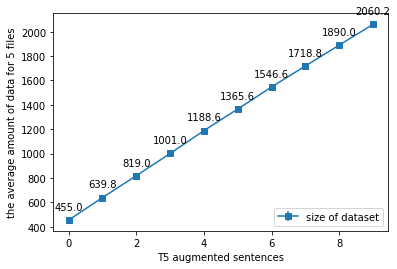

In [15]:
# count the amount of data for cleaned data

data_size=[]
for iii in range(1,6):
  for fi in range(1,11):
    with open('/content/ASOS_project_haoyang/output_result_by_haoyang/data/confident_learning_from_scratch/confidentlearning_applied_T5data/{}cl_mlp_{}.yml'.format(iii,fi),'r') as f:
          data=yaml.safe_load(f)
          data_size.append(count(data))
          


data_size=np.split(np.array(data_size),5)
num_result=np.mean(data_size,axis=0)
num_std=np.std(data_size,axis=0)
import matplotlib.pyplot as plt
import numpy as np
x=np.arange(0,10)
error=[num_std]
# plt.plot(x,num_result)
# plt.errorbar(xval, yval, xerr = 0.4, yerr = 0.5)
plt.errorbar(x,num_result,yerr=num_std,marker='s')

plt.legend(["size of dataset"],loc='lower right')
plt.ylabel('the average amount of data for 5 files')
plt.xlabel('T5 augmented sentences')

for i,j in zip(x,num_result):
  plt.annotate('{}'.format(j), (i,j), 
               textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
from google.colab import files

   
plt.savefig('T5_mlp_cl_data_size.png')
files.download("T5_mlp_cl_data_size.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

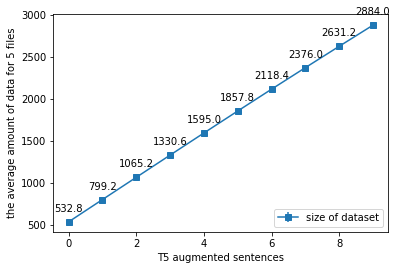

In [38]:
# count the amount of data for cleaned data
data_size=[]
for iii in range(1,6):
  for fi in range(1,11):
    with open('/content/ASOS_project_haoyang/output_result_by_haoyang/data/cv_T5_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi),'r') as f:
          data=yaml.safe_load(f)
          data_size.append(count(data))
          


data_size=np.split(np.array(data_size),5)
num_result=np.mean(data_size,axis=0)
num_std=np.std(data_size,axis=0)
import matplotlib.pyplot as plt
import numpy as np
x=np.arange(0,10)
error=[num_std]
# plt.plot(x,num_result)
# plt.errorbar(xval, yval, xerr = 0.4, yerr = 0.5)
plt.errorbar(x,num_result,yerr=num_std,marker='s')

plt.legend(["size of dataset"],loc='lower right')
plt.ylabel('the average amount of data for 5 files')
plt.xlabel('T5 augmented sentences')

for i,j in zip(x,num_result):
  plt.annotate('{}'.format(j), (i,j), 
               textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
from google.colab import files

   
plt.savefig('T5_data_size.png')
files.download("T5_data_size.png")

In [36]:
def count(data):
  count=0
  for i in data['nlu']:
    count=count+len(i['examples'].split('\n'))-1 
  return count 
  

## GPT3 data size

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

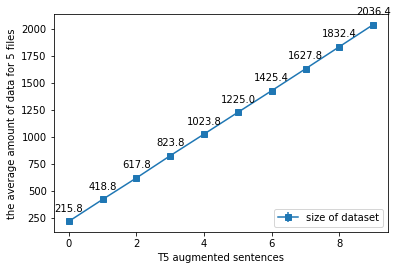

In [39]:
# count the amount of data for cleaned data

data_size=[]
for iii in range(1,6):
  for fi in range(1,11):
    with open('/content/ASOS_project_haoyang/output_result_by_haoyang/data/confident_learning_from_scratch/confidentlearning_applied_gpt3/{}cl_mlp_{}.yml'.format(iii,fi),'r') as f:
          data=yaml.safe_load(f)
          data_size.append(count(data))
          


data_size=np.split(np.array(data_size),5)
num_result=np.mean(data_size,axis=0)
num_std=np.std(data_size,axis=0)
import matplotlib.pyplot as plt
import numpy as np
x=np.arange(0,10)
error=[num_std]
# plt.plot(x,num_result)
# plt.errorbar(xval, yval, xerr = 0.4, yerr = 0.5)
plt.errorbar(x,num_result,yerr=num_std,marker='s')

plt.legend(["size of dataset"],loc='lower right')
plt.ylabel('the average amount of data for 5 files')
plt.xlabel('T5 augmented sentences')

for i,j in zip(x,num_result):
  plt.annotate('{}'.format(j), (i,j), 
               textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
from google.colab import files

   
plt.savefig('GPT_mlp_cl_data_size.png')
files.download("GPT_mlp_cl_data_size.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

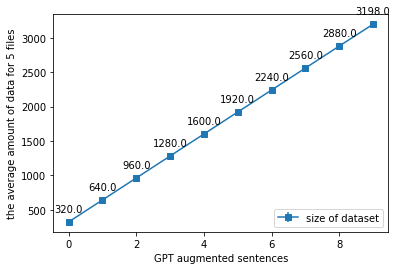

In [40]:
# count the amount of data for cleaned data
data_size=[]
for iii in range(1,6):
  for fi in range(1,11):
    with open('/content/ASOS_project_haoyang/output_result_by_haoyang/data/gpt3_augmented_data/{}cv_{}augumented_fixed.yml'.format(iii,fi),'r') as f:
          data=yaml.safe_load(f)
          data_size.append(count(data))
          


data_size=np.split(np.array(data_size),5)
num_result=np.mean(data_size,axis=0)
num_std=np.std(data_size,axis=0)
import matplotlib.pyplot as plt
import numpy as np
x=np.arange(0,10)
error=[num_std]
# plt.plot(x,num_result)
# plt.errorbar(xval, yval, xerr = 0.4, yerr = 0.5)
plt.errorbar(x,num_result,yerr=num_std,marker='s')

plt.legend(["size of dataset"],loc='lower right')
plt.ylabel('the average amount of data for 5 files')
plt.xlabel('GPT augmented sentences')

for i,j in zip(x,num_result):
  plt.annotate('{}'.format(j), (i,j), 
               textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
from google.colab import files

   
plt.savefig('GPT_data_size.png')
files.download("GPT_data_size.png")